In [108]:
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
import os
import pandas as pd

In [ ]:
with open("../results/ONLINEv1-preTriton-test-EI-eta005/Forrester/seed_0/metrics.json", "r") as f:
    metrics_ei_eta005 = json.load(f)

with open("../results/ONLINEv1-preTriton-test-EI-eta05/Forrester/seed_0/metrics.json", "r") as f:
    metrics_ei_eta05 = json.load(f)
    
with open("../results/ONLINEv1-preTriton-test-UCB-eta05/Forrester/seed_0/metrics.json", "r") as f:
    metrics_ucb_eta05 = json.load(f)
    
with open("../results/ONLINEv1-preTriton-test-UCB-eta005/Forrester/seed_0/metrics.json", "r") as f:
    metrics_ucb_eta005 = json.load(f)

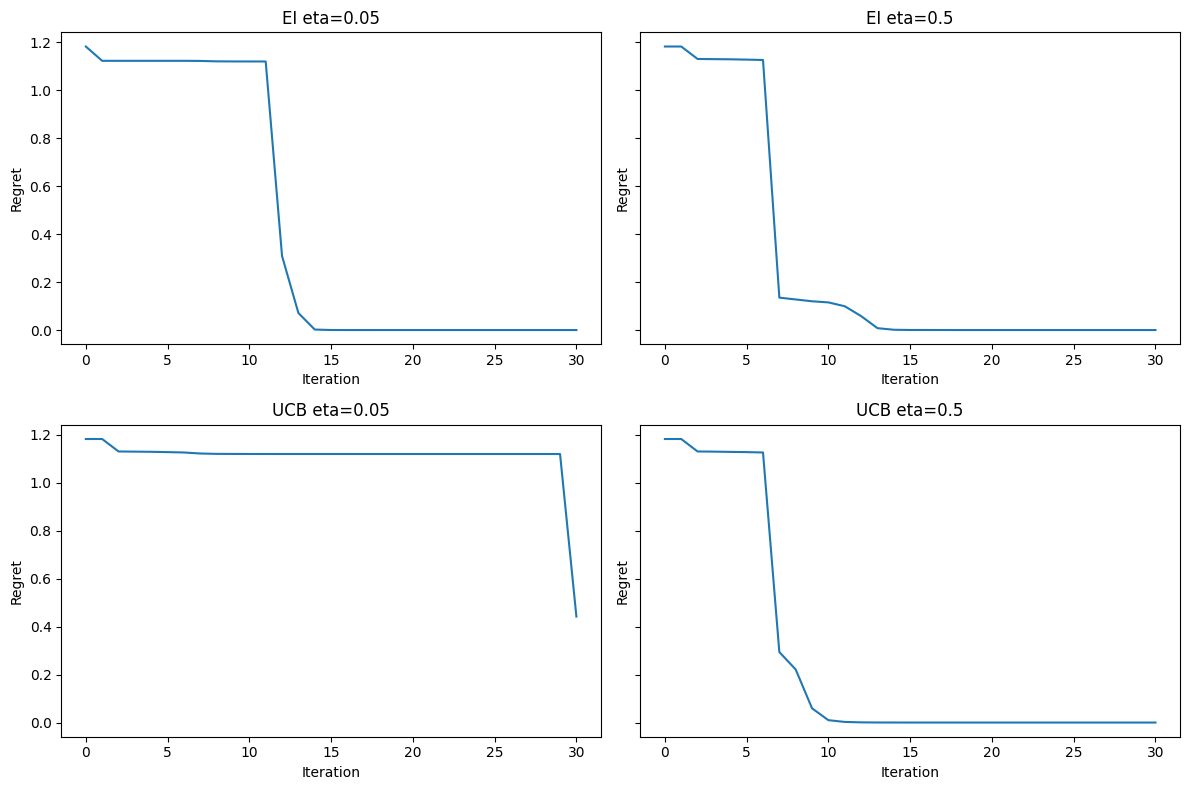

In [181]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)

axes[0, 0].plot(metrics_ei_eta005["y_regret_pool"])
axes[0, 0].set_title("EI eta=0.05")

axes[0, 1].plot(metrics_ei_eta05["y_regret_pool"])
axes[0, 1].set_title("EI eta=0.5")

axes[1, 0].plot(metrics_ucb_eta005["y_regret_pool"])
axes[1, 0].set_title("UCB eta=0.05")

axes[1, 1].plot(metrics_ucb_eta05["y_regret_pool"])
axes[1, 1].set_title("UCB eta=0.5")

for ax in axes.flat:
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Regret")

plt.tight_layout()
plt.show()

In [ ]:
with open("../results/ONLINEv2-preTriton-test-EI-eta005/Forrester/seed_0/metrics.json", "r") as f:
    metrics_v2_ei_eta005 = json.load(f)

with open("../results/ONLINEv2-preTriton-test-EI-eta01/Forrester/seed_0/metrics.json", "r") as f:
    metrics_v2_ei_eta01 = json.load(f)
    
with open("../results/ONLINEv2-preTriton-test-UCB-eta01/Forrester/seed_0/metrics.json", "r") as f:
    metrics_v2_ucb_eta01 = json.load(f)
    
with open("../results/ONLINEv2-preTriton-test-UCB-eta005/Forrester/seed_0/metrics.json", "r") as f:
    metrics_v2_ucb_eta005 = json.load(f)

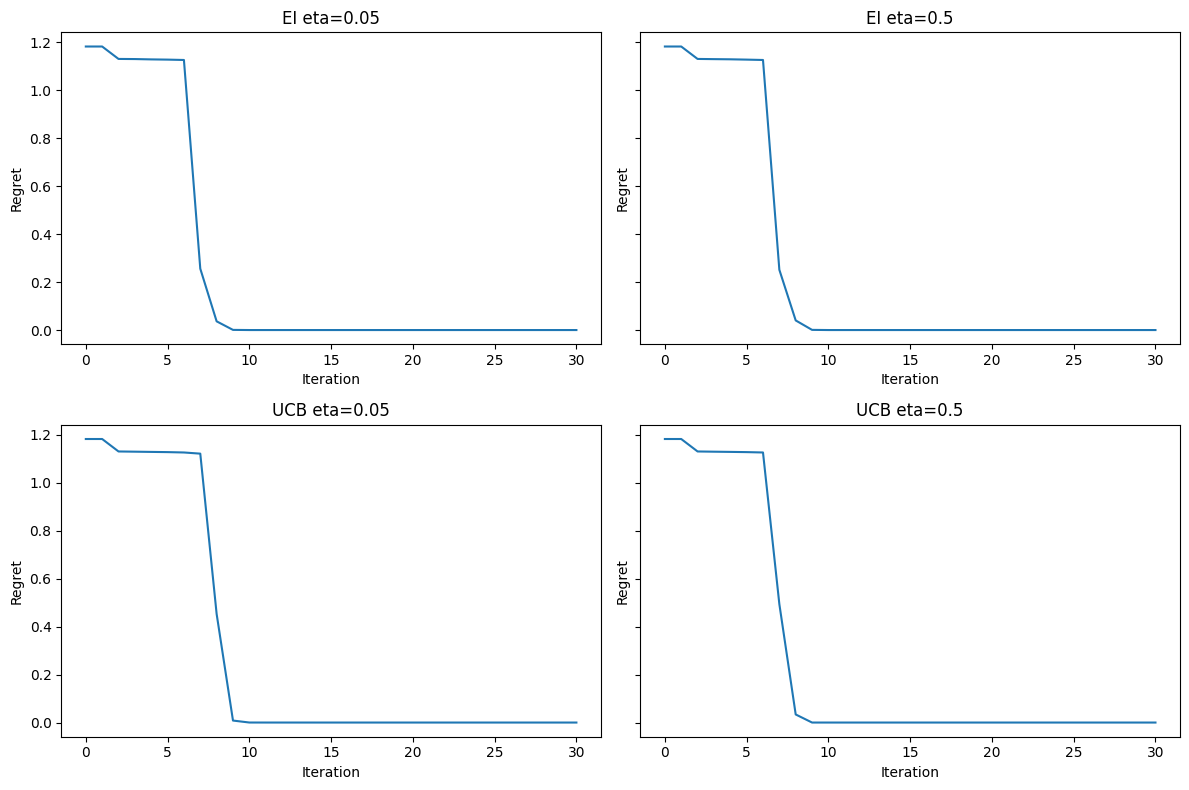

In [183]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)

axes[0, 0].plot(metrics_v2_ei_eta005["y_regret_pool"])
axes[0, 0].set_title("EI eta=0.05")

axes[0, 1].plot(metrics_v2_ei_eta01["y_regret_pool"])
axes[0, 1].set_title("EI eta=0.5")

axes[1, 0].plot(metrics_v2_ucb_eta005["y_regret_pool"])
axes[1, 0].set_title("UCB eta=0.05")

axes[1, 1].plot(metrics_v2_ucb_eta01["y_regret_pool"])
axes[1, 1].set_title("UCB eta=0.5")

for ax in axes.flat:
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Regret")

plt.tight_layout()
plt.show()

In [109]:
def load_runs(results_folder, problem_idx):
    problem_folder = os.path.join(results_folder, f"problem_{problem_idx}")
    if not os.path.isdir(problem_folder):
        raise ValueError(f"Problem folder not found: {problem_folder}")

    seed_folders = [os.path.join(problem_folder, d) for d in os.listdir(problem_folder)
                    if os.path.isdir(os.path.join(problem_folder, d)) and d.startswith("seed_")]
    
    metrics_list = []
    for seed_folder in seed_folders:
        metrics_path = os.path.join(seed_folder, "metrics.json")
        if os.path.isfile(metrics_path):
            with open(metrics_path) as f:
                metrics = json.load(f)
            metrics_list.append(metrics)
    
    if not metrics_list:
        raise ValueError("No metrics.json files found for this problem.")

    return metrics_list

def average_metrics(metrics_list, metric_name):
    """
    Averages a specific metric across different runs/seeds by iteration.

    Args:
        metrics_list (list): A list of metrics dictionaries from different runs.
        metric_name (str): The name of the metric to average (e.g., 'y_regret_pool').

    Returns:
        tuple: A tuple containing:
            - np.ndarray: The average of the metric per iteration.
            - np.ndarray: The standard deviation of the metric per iteration.
    """
    metric_values_all_runs = [metrics[metric_name] for metrics in metrics_list]
    
    # Ensure all runs have the same number of iterations
    it_counts = [len(run) for run in metric_values_all_runs]
    if len(set(it_counts)) > 1:
        print("Warning: Runs have different numbers of iterations. Truncating to the shortest run.")
        min_its = min(it_counts)
        metric_values_all_runs = [run[:min_its] for run in metric_values_all_runs]

    metric_array = np.array(metric_values_all_runs)
    num_runs = metric_array.shape[0]

    avg_metric = np.mean(metric_array, axis=0)
    std_metric = np.std(metric_array, axis=0)
    std_err = std_metric / np.sqrt(num_runs)
    
    return avg_metric, std_metric, std_err

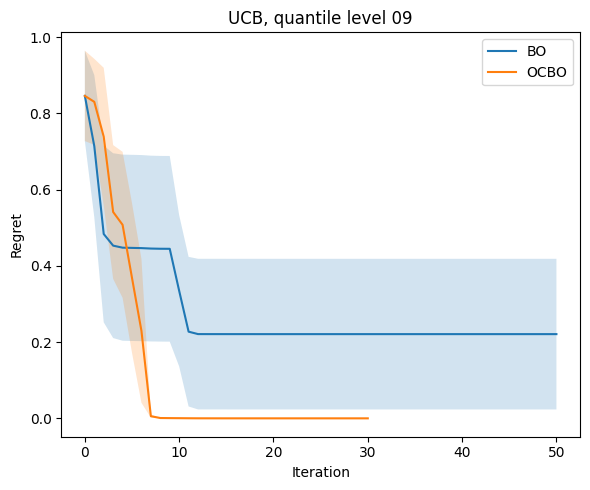

In [115]:
ACQUISITION_FUNCTIONS = ['UCB']
METHODS = ['BO', 'OCBO']
QUANTILE = '09'
BASE_PATH = "results/GP-Forrester"
METRIC_NAME = "y_regret_pool"

# Use a dictionary to store all the results in an organized way
results_data = {}

### 2. Data Loading and Processing Loop ###

# Loop through all combinations to load and process data automatically
for acq_func in ACQUISITION_FUNCTIONS:
    # Create a nested dictionary for each acquisition function
    results_data[acq_func] = {}
    for method in METHODS:
        # Construct the file path dynamically using an f-string
        if method == 'BO':
            path = f"{BASE_PATH}-{acq_func}-{method}-q{QUANTILE}"
        else:
            path = f"{BASE_PATH}-{acq_func}-{method}-q{QUANTILE}"
        # Load the metrics for the current run
        metrics = load_runs(path, 0)
        
        # Calculate the average and standard error
        avg_regret, _, std_err_regret = average_metrics(metrics, METRIC_NAME)
        
        # Store the results in our nested dictionary
        results_data[acq_func][method] = {
            'avg': avg_regret,
            'std_err': std_err_regret
        }


### 3. Plotting Loop ###

# Create subplots dynamically based on the number of acquisition functions
num_plots = len(ACQUISITION_FUNCTIONS)
fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5), sharey=True)

# If there's only one plot, `axes` is not an array, so we wrap it to prevent errors
if num_plots == 1:
    axes = [axes]

# Loop through each acquisition function and its corresponding subplot axis
for ax, acq_func in zip(axes, ACQUISITION_FUNCTIONS):
    # For each acquisition function, plot the results for each method (BO, OCBO)
    for method in METHODS:
        # Retrieve the processed data from our dictionary
        data = results_data[acq_func][method]
        avg_regret = data['avg']
        std_err_regret = data['std_err']
        iterations = np.arange(len(avg_regret))

        # Plot the average regret line
        ax.plot(avg_regret, label=method)
        
        # Plot the shaded standard error region
        ax.fill_between(iterations,
                        avg_regret - std_err_regret,
                        avg_regret + std_err_regret,
                        alpha=0.2)

    # Configure the subplot with dynamic titles and labels
    ax.set_xlabel('Iteration')
    ax.set_title(f'{acq_func}, quantile level {QUANTILE}')
    ax.legend()

# Set the y-axis label only for the first plot to avoid repetition
axes[0].set_ylabel('Regret')

# Adjust layout and display the final plot
plt.tight_layout()
plt.show()


[0.30496879 0.068533   0.05015183 0.03983984 0.03596374 0.03467932
 0.03474146 0.03496142 0.03631416 0.03524089 0.03594769 0.03651896
 0.03745251 0.03822255 0.03972318 0.04013147 0.04119231 0.04234585
 0.04334325 0.04373395 0.04406018 0.04435497 0.0448117  0.04549182
 0.04624239 0.04657348 0.04714295 0.04797463 0.04787532 0.04864472
 0.04915579 0.04968649 0.05002241 0.0505204  0.0509699  0.05143731
 0.05172693 0.05179067 0.05207092 0.05248647 0.0527899  0.05304341
 0.05310329 0.05343624 0.05347087 0.0537307  0.05407784 0.05406729
 0.05415799 0.05442854]
[0.19991616 0.06672826 0.05056809 0.05977353 0.05056521 0.04501739
 0.04058999 0.04049254 0.04151718 0.04253563 0.04356541 0.04382382
 0.04444501 0.04497854 0.0453014  0.04581678 0.04655214 0.0473406
 0.04782109 0.04747974 0.04791791 0.04828825 0.04867965 0.04911783
 0.04964104 0.04960861 0.04906377 0.04937562 0.04939245 0.04878334]


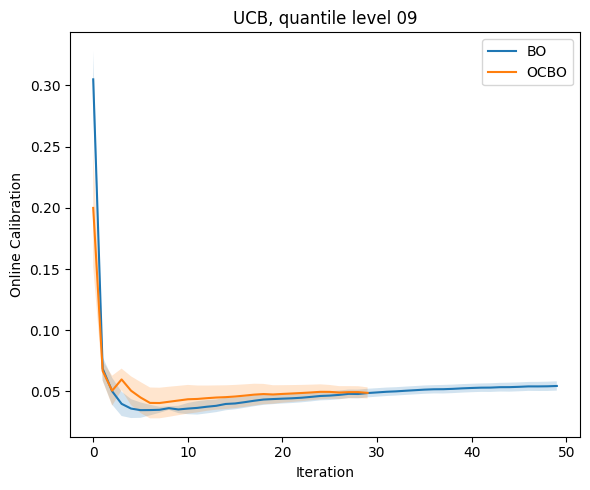

In [105]:
ACQUISITION_FUNCTIONS = ['UCB']
METHODS = ['BO', 'OCBO']
QUANTILE = '09'
BASE_PATH = "results/GP-Forrester"
METRIC_NAME = "online_calibration_mse"

# Use a dictionary to store all the results in an organized way
results_data = {}

### 2. Data Loading and Processing Loop ###

# Loop through all combinations to load and process data automatically
for acq_func in ACQUISITION_FUNCTIONS:
    # Create a nested dictionary for each acquisition function
    results_data[acq_func] = {}
    for method in METHODS:
        # Construct the file path dynamically using an f-string
        path = f"{BASE_PATH}-{acq_func}-{method}-q{QUANTILE}"
        
        # Load the metrics for the current run
        metrics = load_runs(path, 0)
        
        # Calculate the average and standard error
        avg_regret, _, std_err_regret = average_metrics(metrics, METRIC_NAME)
        
        # Store the results in our nested dictionary
        results_data[acq_func][method] = {
            'avg': avg_regret,
            'std_err': std_err_regret
        }


### 3. Plotting Loop ###

# Create subplots dynamically based on the number of acquisition functions
num_plots = len(ACQUISITION_FUNCTIONS)
fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5), sharey=True)

# If there's only one plot, `axes` is not an array, so we wrap it to prevent errors
if num_plots == 1:
    axes = [axes]

# Loop through each acquisition function and its corresponding subplot axis
for ax, acq_func in zip(axes, ACQUISITION_FUNCTIONS):
    # For each acquisition function, plot the results for each method (BO, OCBO)
    for method in METHODS:
        # Retrieve the processed data from our dictionary
        data = results_data[acq_func][method]
        avg_regret = data['avg']
        std_err_regret = data['std_err']
        iterations = np.arange(len(avg_regret))

        # Plot the average regret line
        ax.plot(avg_regret, label=method)
        print(avg_regret)
        # Plot the shaded standard error region
        ax.fill_between(iterations,
                        avg_regret - std_err_regret,
                        avg_regret + std_err_regret,
                        alpha=0.2)

    # Configure the subplot with dynamic titles and labels
    ax.set_xlabel('Iteration')
    ax.set_title(f'{acq_func}, quantile level {QUANTILE}')
    ax.legend()

# Set the y-axis label only for the first plot to avoid repetition
axes[0].set_ylabel('Online Calibration')

# Adjust layout and display the final plot
plt.tight_layout()
plt.show()


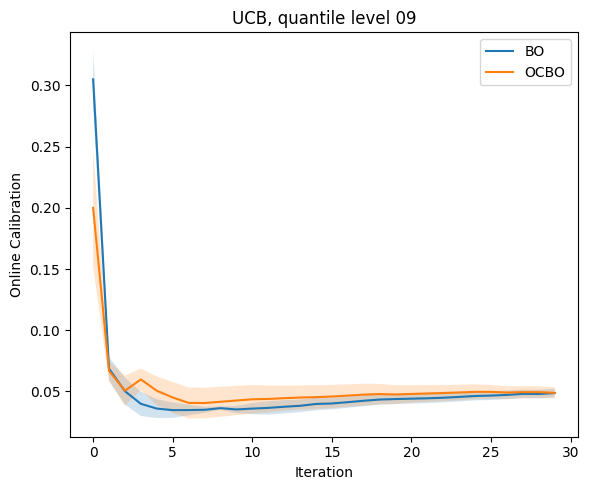

In [93]:
ACQUISITION_FUNCTIONS = ['UCB']
METHODS = ['BO', 'OCBO']
QUANTILE = '09'
BASE_PATH = "results/GP-Forrester"
METRIC_NAME = "online_calibration_mse"

# Use a dictionary to store all the results in an organized way
results_data = {}

### 2. Data Loading and Processing Loop ###

# Loop through all combinations to load and process data automatically
for acq_func in ACQUISITION_FUNCTIONS:
    # Create a nested dictionary for each acquisition function
    results_data[acq_func] = {}
    for method in METHODS:
        # Construct the file path dynamically using an f-string
        path = f"{BASE_PATH}-{acq_func}-{method}-q{QUANTILE}"
        
        # Load the metrics for the current run
        metrics = load_runs(path, 0)
        
        # Calculate the average and standard error
        avg_regret, _, std_err_regret = average_metrics(metrics, METRIC_NAME)
        
        # Store the results in our nested dictionary
        results_data[acq_func][method] = {
            'avg': avg_regret,
            'std_err': std_err_regret
        }


### 3. Plotting Loop ###

# Create subplots dynamically based on the number of acquisition functions
num_plots = len(ACQUISITION_FUNCTIONS)
fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5), sharey=True)

# If there's only one plot, `axes` is not an array, so we wrap it to prevent errors
if num_plots == 1:
    axes = [axes]

# Loop through each acquisition function and its corresponding subplot axis
for ax, acq_func in zip(axes, ACQUISITION_FUNCTIONS):
    # For each acquisition function, plot the results for each method (BO, OCBO)
    for method in METHODS:
        # Retrieve the processed data from our dictionary
        data = results_data[acq_func][method]
        avg_regret = data['avg']
        std_err_regret = data['std_err']
        iterations = np.arange(len(avg_regret))

        # Plot the average regret line
        ax.plot(avg_regret, label=method)
        
        # Plot the shaded standard error region
        ax.fill_between(iterations,
                        avg_regret - std_err_regret,
                        avg_regret + std_err_regret,
                        alpha=0.2)

    # Configure the subplot with dynamic titles and labels
    ax.set_xlabel('Iteration')
    ax.set_title(f'{acq_func}, quantile level {QUANTILE}')
    ax.legend()

# Set the y-axis label only for the first plot to avoid repetition
axes[0].set_ylabel('Online Calibration')

# Adjust layout and display the final plot
plt.tight_layout()
plt.show()

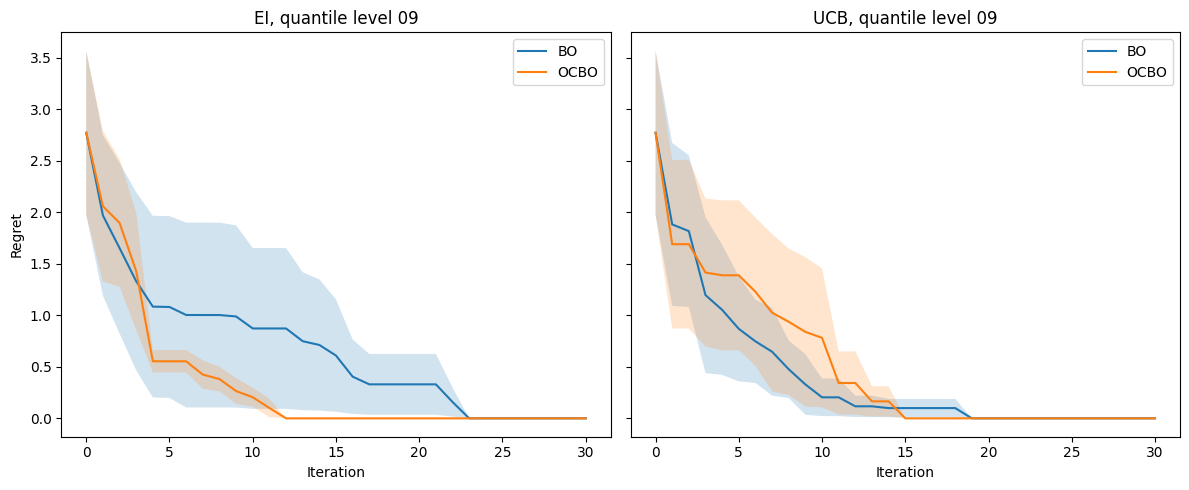

In [65]:
ACQUISITION_FUNCTIONS = ['EI', 'UCB']
METHODS = ['BO', 'OCBO']
QUANTILE = '09'
BASE_PATH = "results/GP-Ackley"
METRIC_NAME = "y_regret_pool"

# Use a dictionary to store all the results in an organized way
results_data = {}

### 2. Data Loading and Processing Loop ###

# Loop through all combinations to load and process data automatically
for acq_func in ACQUISITION_FUNCTIONS:
    # Create a nested dictionary for each acquisition function
    results_data[acq_func] = {}
    for method in METHODS:
        # Construct the file path dynamically using an f-string
        path = f"{BASE_PATH}-{acq_func}-{method}-q{QUANTILE}"
        
        # Load the metrics for the current run
        metrics = load_runs(path, 0)
        
        # Calculate the average and standard error
        avg_regret, _, std_err_regret = average_metrics(metrics, METRIC_NAME)
        
        # Store the results in our nested dictionary
        results_data[acq_func][method] = {
            'avg': avg_regret,
            'std_err': std_err_regret
        }


### 3. Plotting Loop ###

# Create subplots dynamically based on the number of acquisition functions
num_plots = len(ACQUISITION_FUNCTIONS)
fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5), sharey=True)

# If there's only one plot, `axes` is not an array, so we wrap it to prevent errors
if num_plots == 1:
    axes = [axes]

# Loop through each acquisition function and its corresponding subplot axis
for ax, acq_func in zip(axes, ACQUISITION_FUNCTIONS):
    # For each acquisition function, plot the results for each method (BO, OCBO)
    for method in METHODS:
        # Retrieve the processed data from our dictionary
        data = results_data[acq_func][method]
        avg_regret = data['avg']
        std_err_regret = data['std_err']
        iterations = np.arange(len(avg_regret))

        # Plot the average regret line
        ax.plot(avg_regret, label=method)
        
        # Plot the shaded standard error region
        ax.fill_between(iterations,
                        avg_regret - std_err_regret,
                        avg_regret + std_err_regret,
                        alpha=0.2)

    # Configure the subplot with dynamic titles and labels
    ax.set_xlabel('Iteration')
    ax.set_title(f'{acq_func}, quantile level {QUANTILE}')
    ax.legend()

# Set the y-axis label only for the first plot to avoid repetition
axes[0].set_ylabel('Regret')

# Adjust layout and display the final plot
plt.tight_layout()
plt.show()


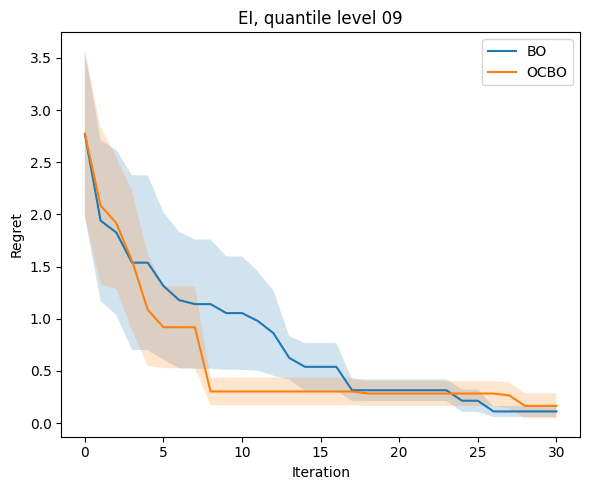

In [81]:
ACQUISITION_FUNCTIONS = ['EI']
METHODS = ['BO', 'OCBO']
QUANTILE = '09'
BASE_PATH = "results/GP-Ackley"
METRIC_NAME = "y_regret_pool"

# Use a dictionary to store all the results in an organized way
results_data = {}

### 2. Data Loading and Processing Loop ###

# Loop through all combinations to load and process data automatically
for acq_func in ACQUISITION_FUNCTIONS:
    # Create a nested dictionary for each acquisition function
    results_data[acq_func] = {}
    for method in METHODS:
        # Construct the file path dynamically using an f-string
        path = f"{BASE_PATH}-{acq_func}-{method}-q{QUANTILE}-scaletest"
        
        # Load the metrics for the current run
        metrics = load_runs(path, 0)
        
        # Calculate the average and standard error
        avg_regret, _, std_err_regret = average_metrics(metrics, METRIC_NAME)
        
        # Store the results in our nested dictionary
        results_data[acq_func][method] = {
            'avg': avg_regret,
            'std_err': std_err_regret
        }


### 3. Plotting Loop ###

# Create subplots dynamically based on the number of acquisition functions
num_plots = len(ACQUISITION_FUNCTIONS)
fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5), sharey=True)

# If there's only one plot, `axes` is not an array, so we wrap it to prevent errors
if num_plots == 1:
    axes = [axes]

# Loop through each acquisition function and its corresponding subplot axis
for ax, acq_func in zip(axes, ACQUISITION_FUNCTIONS):
    # For each acquisition function, plot the results for each method (BO, OCBO)
    for method in METHODS:
        # Retrieve the processed data from our dictionary
        data = results_data[acq_func][method]
        avg_regret = data['avg']
        std_err_regret = data['std_err']
        iterations = np.arange(len(avg_regret))

        # Plot the average regret line
        ax.plot(avg_regret, label=method)
        
        # Plot the shaded standard error region
        ax.fill_between(iterations,
                        avg_regret - std_err_regret,
                        avg_regret + std_err_regret,
                        alpha=0.2)

    # Configure the subplot with dynamic titles and labels
    ax.set_xlabel('Iteration')
    ax.set_title(f'{acq_func}, quantile level {QUANTILE}')
    ax.legend()

# Set the y-axis label only for the first plot to avoid repetition
axes[0].set_ylabel('Regret')

# Adjust layout and display the final plot
plt.tight_layout()
plt.show()


In [157]:
with open("results/UNIBOv1-Forrester-UCB/problem_0/seed_0/metrics.json") as f:
    metricsV1 = json.load(f)
    
with open("results/UNIBOv1-Forrester-UCB/problem_0/seed_0/dataset.json") as f:
    datasetV1 = json.load(f)
    
with open("results/UNIBOv2-Forrester-UCB/problem_0/seed_0/metrics.json") as f:
    metricsV2 = json.load(f)
    
with open("results/UNIBO-Forrester-UCB/problem_0/seed_0/metrics.json") as f:
    metricsBO = json.load(f)

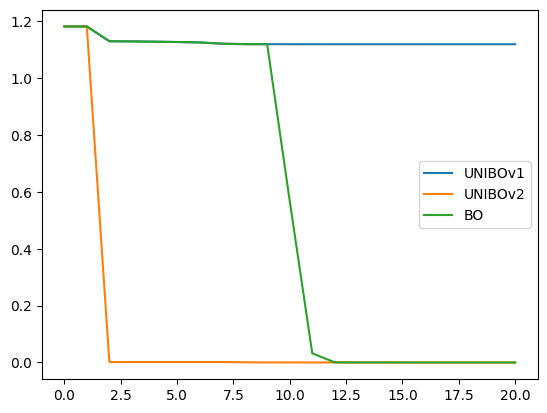

In [158]:
plt.plot(metricsV1['y_regret_pool'], label='UNIBOv1')
plt.plot(metricsV2['y_regret_pool'], label='UNIBOv2')
plt.plot(metricsBO['y_regret_pool'], label='BO')
plt.legend()
plt.show()

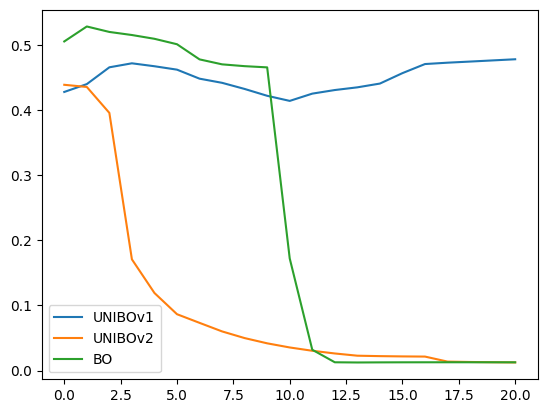

In [159]:
plt.plot(metricsV1['crps_test'], label='UNIBOv1')
plt.plot(metricsV2['crps_test'], label='UNIBOv2')
plt.plot(metricsBO['crps_test'], label='BO')
plt.legend()
plt.show()

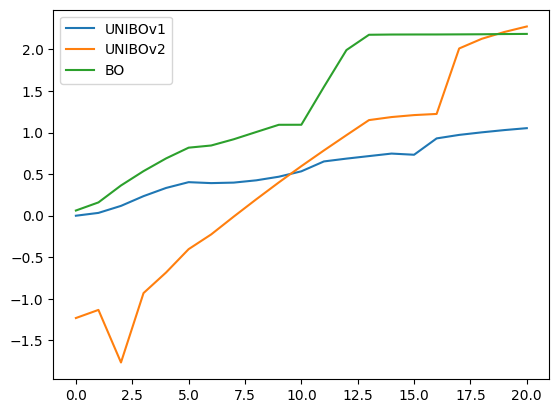

In [153]:
plt.plot(metricsV1['mean_sharpness'], label='UNIBOv1')
plt.plot(metricsV2['mean_sharpness'], label='UNIBOv2')
plt.plot(metricsBO['mean_sharpness'], label='BO')
plt.legend()
plt.show()